In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# jax
import jax.numpy as jnp
from jax import random
import time

# collocation
import sys
import os
p_ = os.path.abspath(os.path.join('..', '00_utils'))
if p_ not in sys.path:
    sys.path.append(p_)
    
p_ = os.path.abspath(os.path.join('..', '00_models'))
if p_ not in sys.path:
    sys.path.append(p_)

from collocation import compute_weights, lagrange_derivative
from non_parametric_collocation import collocate_data

import preprocess # helper preprocessing class
import ode_solver_pyomo_base
import ode_solver_pyomo_opt

# pyomo
import importlib
import nn_pyomo_base
import nn_pyomo_base_dae

In [12]:
importlib.reload(preprocess)
DataPreprocessor = preprocess.DataPreprocessor

importlib.reload(ode_solver_pyomo_opt)
DirectODESolver = ode_solver_pyomo_opt.DirectODESolver

# set up data parameters
file_path = '../00_data/df_train.csv'
# , 'temperature': 'var1'                                               
encoding = {'settlement_date': 't', 'temperature': 'var1', 'hour': 'var2', 'nd': 'y'}

# fix model parameters 
layer_sizes = [8, 30, 1]

# fix optimal parameters
tol = 1e-8
params_nn = {"tol":tol, "detailed_output": True,
        "dual_inf_tol": tol, "compl_inf_tol": tol, "constr_viol_tol": tol, 
        "halt_on_ampl_error" : 'yes', "print_level": 5, "max_iter": 500}

tol = 1e-4
params_ode = {"tol":1e-4, 
        "dual_inf_tol": tol, "compl_inf_tol": tol, "constr_viol_tol": tol, 
        "acceptable_iter": 0,  
        "halt_on_ampl_error" : 'yes',
        "print_level": 1, 
        "max_iter": 100 }

In [13]:
from datetime import datetime, timedelta

# prepare data ranges
START_DATE = '2015-01-10'
start_date = datetime.strptime(START_DATE, '%Y-%m-%d')
date_sequences = [start_date + timedelta(days=i*5) for i in range(1)]
date_sequences_str = [date.strftime('%Y-%m-%d') for date in date_sequences]
print(date_sequences_str)

times_elapsed = []

['2015-01-10']


In [14]:
importlib.reload(preprocess)
DataPreprocessor = preprocess.DataPreprocessor

data_loader = DataPreprocessor(file_path, start_date = START_DATE, number_of_points = 400, n_days = 1, m = 2, feature_encoding = encoding, split=200, num_nodes_mult= 1.5)
data_subsample = data_loader.load_data()
df_train, df_test = data_loader.preprocess_data(data_subsample)

In [15]:
# reload the necessary libraries
importlib.reload(nn_pyomo_base)
NeuralODEPyomo = nn_pyomo_base.NeuralODEPyomo

experiment_results = {}

iter = 0
skip_training = False

for START_DATE in date_sequences_str:
    
    if not skip_training:
        data_loader = DataPreprocessor(file_path, start_date = START_DATE, number_of_points = 400, n_days = 1, m = 2, feature_encoding = encoding, split = 200, num_nodes_mult = 1)
        data_subsample = data_loader.load_data()
        df_train, df_test = data_loader.preprocess_data(data_subsample)

        ys = np.atleast_2d(df_train['y']).T
        ts = np.array(df_train['t'])
        Xs = np.atleast_2d(df_train.drop(columns=['y', 't']))

        if iter == 0:
            w = compute_weights(df_train['t'])
            Ds = np.array(lagrange_derivative(df_train['t'], w))
        iter+=1

        ode_model = NeuralODEPyomo(y_observed = ys, 
                                t = ts, # t
                                first_derivative_matrix = Ds, # derivative matrix
                                extra_input = Xs, # extra inputs
                                y_init = ys,
                                layer_sizes = layer_sizes, act_func = "tanh", 
                                penalty_lambda_reg = 0.01, 
                                time_invariant = True,
                                w_init_method = 'xavier', 
                                params = params_nn
                                )

        ode_model.build_model()
        result = ode_model.solve_model()
        u_model = ode_model.extract_solution().T
        
    experiment_results[START_DATE] = {}
    experiment_results[START_DATE]['times_elapsed'] = result['solver_time']
    
    # ---------------------------------------------- ODEINT PREDICTION ----------------------------------------------
    y0 = ys[0]
    y_pred = ode_model.neural_ode(y0, ts, (Xs, ts), rtol = 1e-2, atol = 1e-2, dt0 = 1e-10)
    experiment_results[START_DATE]['mae_diffeqsolve'] = np.mean(np.abs(np.squeeze(y_pred) - np.squeeze(ys)))
    experiment_results[START_DATE]['mse_diffeqsolve'] = np.mean(np.square(np.squeeze(y_pred) - np.squeeze(ys)))
    
    y_pred = ode_model.neural_ode_odeint(y0, ts, (Xs, ts))
    experiment_results[START_DATE]['mae_odeint'] = np.mean(np.abs(np.squeeze(y_pred) - np.squeeze(ys)))
    experiment_results[START_DATE]['mse_odeint'] = np.mean(np.square(np.squeeze(y_pred) - np.squeeze(ys)))
    
    if True:
        plt.figure(figsize=(20, 10))
        plt.plot(ts, ys, label='True Data', alpha = 1)
        plt.plot(ts, u_model, label='True Data', alpha = 1)
        plt.scatter(ts, y_pred, label='Model Prediction (Train) - Odeint', alpha = 0.7)
        plt.title(f"Sequential ODE Solver Result; Time Elapsed: {result['solver_time']:.3f}")
        plt.legend(loc ="lower right")
        plt.grid(True)
        plt.savefig(f'plots/pyomo/ode_solver_train_{START_DATE}.png', format='png')  
        plt.close() 
    
    # -------------------------------------------- COLLOCATION PREDICTION (TRAIN) ---------------------------------------------- 
    # extract weights & biases
    trained_weights_biases = ode_model.extract_weights()
    trained_weights = trained_weights_biases['W1'], trained_weights_biases['W2']
    trained_biases = trained_weights_biases['b1'], trained_weights_biases['b2']    
    
    # set up and solve the model
    initial_state = u_model[0]
    direct_solver = DirectODESolver(np.array(ts), layer_sizes, trained_weights, trained_biases, initial_state, 
                                    D = Ds, time_invariant=True, extra_input=np.array(Xs), params = params_ode)
    direct_solver.build_model()
    solver_info = direct_solver.solve_model()
    y_solution = direct_solver.extract_solution()     
    
    if True:
        plt.figure(figsize=(20, 10))
        plt.plot(ts, ys, label='True Data', alpha = 1)
        plt.plot(ts, u_model, label='True Data', alpha = 1)
        plt.plot(ts, y_solution, label='Model Prediction (Train) - Collocation-based ODE', alpha = 0.7)
        plt.title(f"Collocation-based ODE Solver Result; Time Elapsed: {result['solver_time']:.3f}")
        plt.legend(loc ="lower right")
        plt.grid(True)
        plt.savefig(f'plots/pyomo/collocation_solver_train_{START_DATE}.png', format='png')  
        plt.close() 
    
    experiment_results[START_DATE]['mae_coll_ode'] = np.mean(np.abs(np.squeeze(y_solution) - np.squeeze(ys)))
    experiment_results[START_DATE]['mse_coll_ode'] = np.mean(np.square(np.squeeze(y_solution) - np.squeeze(ys)))

y
Ipopt 3.14.16: tol=1e-08
output_file=ipopt_output.log
dual_inf_tol=1e-08
compl_inf_tol=1e-08
constr_viol_tol=1e-08
halt_on_ampl_error=yes
print_level=5
max_iter=500


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    99670
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    61521

Total number of variables............................:      501
                     variables with only lower bounds:        0
                variables with lower and upper bound

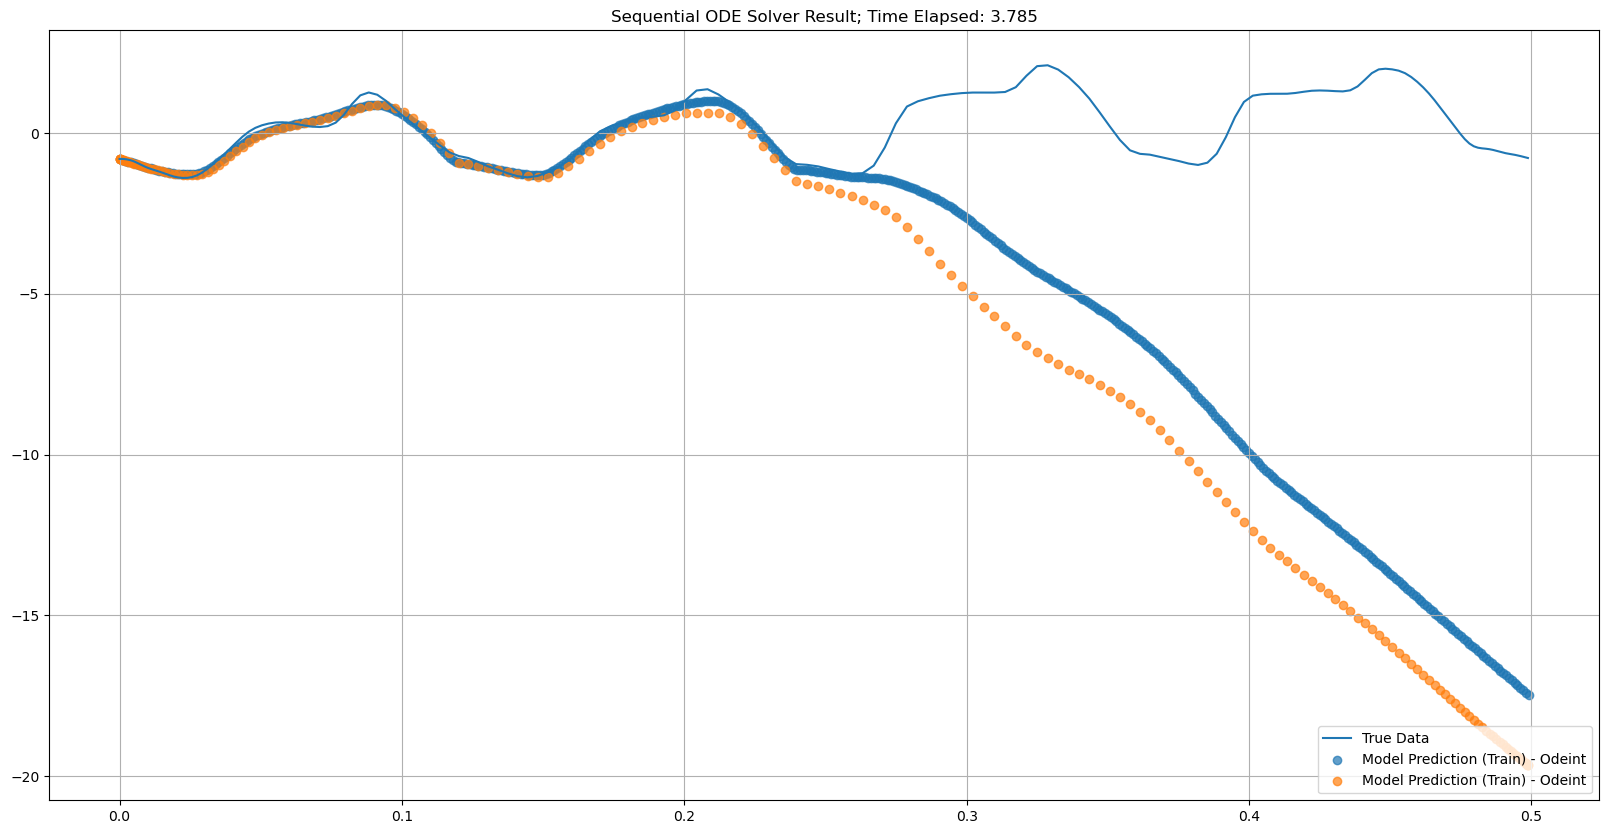

In [17]:
y_euler = ode_model.neural_ode_euler(y0, ts, (Xs, ts))
t_vode, y_vode = ode_model.neural_ode_vode(y0, ts, (Xs, ts), rtol = 1e-3, atol = 1e-6, nsteps = 1000)

plt.figure(figsize=(20, 10))
plt.plot(ts, ys, label='True Data', alpha = 1)
plt.scatter(t_vode, y_vode, label='Model Prediction (Train) - Odeint', alpha = 0.7)
plt.scatter(ts, y_euler, label='Model Prediction (Train) - Odeint', alpha = 0.7)
plt.title(f"Sequential ODE Solver Result; Time Elapsed: {result['solver_time']:.3f}")
plt.legend(loc ="lower right")
plt.grid(True)

In [10]:
print(f"MAE train (odeint): {np.mean([experiment_results[k]['mae_odeint'] for k in experiment_results.keys()]):.3f}")
print(f"MSE train (odeint): {np.mean([experiment_results[k]['mse_odeint'] for k in experiment_results.keys()]):.3f}")

print(f"MAE train (diffeqsolve): {np.mean([experiment_results[k]['mae_diffeqsolve'] for k in experiment_results.keys()]):.3f}")
print(f"MSE train (diffeqsolve): {np.mean([experiment_results[k]['mse_diffeqsolve'] for k in experiment_results.keys()]):.3f}")

print(f"MAE train: {np.mean([experiment_results[k]['mae_coll_ode'] for k in experiment_results.keys()]):.3f}")
print(f"MSE train: {np.mean([experiment_results[k]['mse_coll_ode'] for k in experiment_results.keys()]):.3f}")
print(f"Avg sovler time elapsed: {np.mean([experiment_results[k]['times_elapsed'] for k in experiment_results.keys()]):.3} seconds")

MAE train (odeint): 9.763
MSE train (odeint): 209.510
MAE train (diffeqsolve): 8.163
MSE train (diffeqsolve): 151.948
MAE train: 0.257
MSE train: 0.200
Avg sovler time elapsed: 3.47 seconds
